# Analysis and visualization of typing data
load data and filter starting logs that will not be used for further analysis 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import json
import typing

data_item = pd.read_csv('../csv/umimeprogramovatcz-psani_deseti_item.csv', sep=';')
data_final_logs = pd.read_csv('../csv/final_logs_new_3.csv', sep=';')
sns.set()
pd.set_option('mode.chained_assignment', None)

In [2]:
# filter out starting logs from final logs
print('Number of all exercises with starting logs: ', data_final_logs.shape)
# remove invalid logs - min "moves" in every every exercise is 50 and min "responseTime" should be at least 8s
valid_final_logs = data_final_logs[(data_final_logs['moves'] >= 45) & (data_final_logs['responseTime'] > 8000)]
print('Starting logs filtered out: ', valid_final_logs.shape)

Number of all exercises with starting logs:  (1021699, 9)
Starting logs filtered out:  (742181, 9)


## Initial data analysis
inspect data distribution, extreme values, correlation of different atributes

time over 20min: 33976
more than 10 error in a row: 43270
WPM over 120: 2402
WPM less than 15: 86594


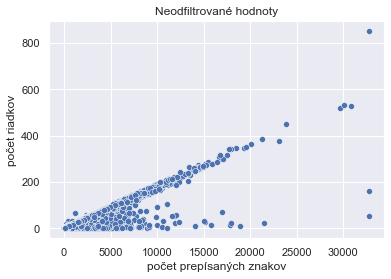

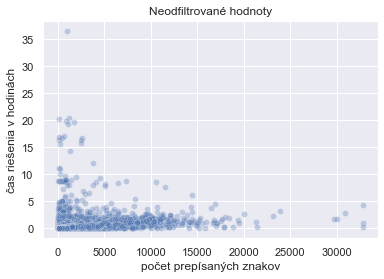

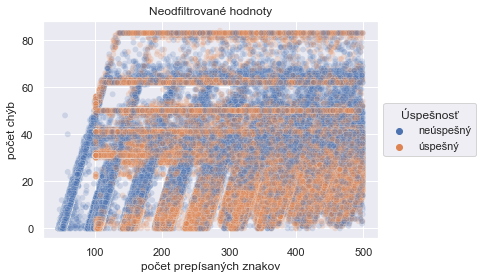

,id,user,item,correct,moves,responseTime,log_count,wpm,error_count,error_seq,responseTime_hours
count,7.421810e+05,7.421810e+05,742181.000000,742181.000000,742181.000000,7.421810e+05,742181.000000,742181.000000,742181.000000,742181.00000,742181.000000
mean,1.892119e+06,2.825814e+07,110.707085,0.459032,312.384205,1.746602e+05,3.923928,28.571686,15.153329,3.93438,0.048517
std,1.008279e+06,5.575681e+06,70.655666,0.498319,478.610725,5.251490e+05,8.042131,17.531326,16.838375,8.19490,0.145875
min,1.340000e+02,2.000000e+00,6.000000,0.000000,45.000000,8.050000e+03,0.000000,0.021512,0.000000,0.00000,0.002236
25%,1.298143e+06,2.798533e+07,32.000000,0.000000,105.000000,4.375000e+04,0.000000,19.984140,2.000000,1.00000,0.012153
50%,1.706681e+06,2.970510e+07,141.000000,0.000000,166.000000,8.125000e+04,2.000000,26.440678,8.000000,2.00000,0.022569
75%,2.638273e+06,3.097808e+07,153.000000,1.000000,350.000000,1.794000e+05,4.000000,33.903346,24.000000,3.00000,0.049833
90%,3.441716e+06,3.312028e+07,198.000000,1.000000,663.000000,3.685500e+05,9.000000,43.260281,39.000000,5.00000,0.102375
95%,3.706871e+06,3.380018e+07,216.000000,1.000000,968.000000,5.697500e+05,15.000000,51.770574,50.000000,14.00000,0.158264
max,3.971622e+06,3.463113e+07,250.000000,1.000000,32767.000000,1.316114e+08,852.000000,4206.928406,84.000000,84.00000,36.558708


In [3]:
import importlib
import data_analysis
importlib.reload(data_analysis)
from data_analysis import basic_analysis_graphs, get_typing_speed_wpm, get_number_errors, get_max_error_sequence


valid_final_logs['wpm'] = valid_final_logs.apply(lambda x: get_typing_speed_wpm(x.responseTime, x.moves), axis=1)
valid_final_logs['error_count'] = valid_final_logs['answer'].apply(get_number_errors)
valid_final_logs['error_seq'] = valid_final_logs['answer'].apply(get_max_error_sequence)

print('time over 20min:', valid_final_logs[valid_final_logs['responseTime'] > 600000].shape[0])
print('more than 10 error in a row:', valid_final_logs[valid_final_logs['error_seq'] > 10].shape[0])
print('WPM over 120:', valid_final_logs[valid_final_logs['wpm'] > 120].shape[0])
print('WPM less than 15:', valid_final_logs[valid_final_logs['wpm'] < 15].shape[0])

basic_analysis_graphs(valid_final_logs, 'Neodfiltrované hodnoty')
valid_final_logs.describe(percentiles=[0.25, 0.50, 0.75, 0.9, 0.95])

In [4]:
## correlation of exercise parameters
valid_final_logs.corr()

,id,user,item,correct,moves,responseTime,log_count,wpm,error_count,error_seq,responseTime_hours
id,1.000000,0.303079,0.022394,0.067041,0.031816,0.012345,0.057767,0.022626,-0.036602,0.025437,0.012345
user,0.303079,1.000000,0.015444,0.039797,0.047098,0.027825,0.060801,-0.026542,0.014958,-0.048734,0.027825
item,0.022394,0.015444,1.000000,-0.064669,0.045929,0.017241,0.044943,0.044429,0.044718,0.006581,0.017241
correct,0.067041,0.039797,-0.064669,1.000000,-0.003165,-0.039897,0.119942,0.207663,-0.128392,0.054415,-0.039897
moves,0.031816,0.047098,0.045929,-0.003165,1.000000,0.463108,0.877178,0.077020,0.550215,0.111310,0.463108
responseTime,0.012345,0.027825,0.017241,-0.039897,0.463108,1.000000,0.434677,-0.134874,0.276255,0.025491,1.000000
log_count,0.057767,0.060801,0.044943,0.119942,0.877178,0.434677,1.000000,-0.004920,0.407022,0.023411,0.434677
wpm,0.022626,-0.026542,0.044429,0.207663,0.077020,-0.134874,-0.004920,1.000000,0.079882,0.266589,-0.134874
error_count,-0.036602,0.014958,0.044718,-0.128392,0.550215,0.276255,0.407022,0.079882,1.000000,0.551534,0.276255
error_seq,0.025437,-0.048734,0.006581,0.054415,0.111310,0.025491,0.023411,0.266589,0.551534,1.000000,0.025491


filtered logs count:  617207


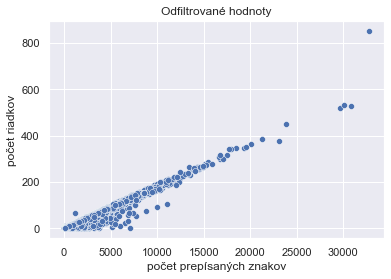

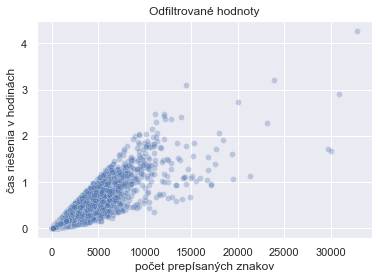

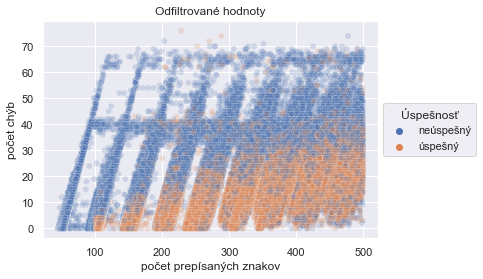

,id,user,item,correct,moves,responseTime,log_count,wpm,error_count,error_seq,responseTime_hours
count,6.172070e+05,6.172070e+05,617207.000000,617207.000000,617207.000000,6.172070e+05,617207.000000,617207.000000,617207.000000,617207.000000,617207.000000
mean,1.873626e+06,2.828490e+07,110.560206,0.492101,303.408299,1.383607e+05,3.960383,29.643579,13.053614,2.179878,0.038434
std,1.007262e+06,5.545272e+06,70.583909,0.499938,463.145951,2.235429e+05,8.153798,10.464479,14.937815,1.493802,0.062095
min,1.340000e+02,2.000000e+00,6.000000,0.000000,45.000000,8.050000e+03,0.000000,15.000000,0.000000,0.000000,0.002236
25%,1.268620e+06,2.797324e+07,32.000000,0.000000,105.000000,4.065000e+04,0.000000,22.338902,2.000000,1.000000,0.011292
50%,1.697103e+06,2.970510e+07,140.000000,0.000000,163.000000,7.180000e+04,2.000000,27.666195,7.000000,2.000000,0.019944
75%,2.610802e+06,3.097413e+07,153.000000,1.000000,335.000000,1.534500e+05,4.000000,34.424899,19.000000,3.000000,0.042625
90%,3.425102e+06,3.311203e+07,197.000000,1.000000,642.000000,3.018000e+05,9.000000,42.650412,36.000000,4.000000,0.083833
95%,3.693288e+06,3.378610e+07,216.000000,1.000000,937.000000,4.507000e+05,15.000000,49.411765,43.000000,5.000000,0.125194
max,3.971622e+06,3.463113e+07,250.000000,1.000000,32767.000000,1.537630e+07,852.000000,120.000000,76.000000,10.000000,4.271194


In [5]:
## filter data

valid_final_logs_new = valid_final_logs[(valid_final_logs['wpm'].between(15,120)) & (valid_final_logs['error_seq'] <= 10)]
print('filtered logs count: ', valid_final_logs_new.shape[0])


basic_analysis_graphs(valid_final_logs_new, 'Odfiltrované hodnoty')

valid_final_logs = valid_final_logs_new
valid_final_logs.describe(percentiles=[0.25, 0.50, 0.75, 0.9, 0.95])


In [6]:
from utils import create_groups_of_exercises, add_ordering_to_exercise_group_dict, get_absolute_ordering

# order exercises based on ordering on page
exercise_info_ps_problem = pd.read_csv('../csv/umimeprogramovatcz-system_ps_problem.csv', sep=';')
exercise_info_ps = pd.read_csv('../csv/umimeprogramovatcz-system_ps.csv', sep=';')


psani_deseti_ps = exercise_info_ps[exercise_info_ps['url'].str.contains('psani-vsemi')]
psani_deseti_ps_ids = psani_deseti_ps['id'].tolist()


exercise_groups_temp = create_groups_of_exercises(exercise_info_ps_problem, psani_deseti_ps_ids)
add_ordering_to_exercise_group_dict(exercise_groups_temp, psani_deseti_ps)
absolute_order_dict = get_absolute_ordering(data_item, exercise_groups_temp)

exercise_groups = dict()
for value in exercise_groups_temp.values():
    exercise_groups[value['ordering']] = (value['group'], value['name'])

exercise_to_group_dict = dict()
for values in exercise_groups_temp.values():
    for exercise in values['group']:
        exercise_to_group_dict[exercise] = (values['name'], values['ordering'])

data_item['item_order'] = data_item['id'].map(absolute_order_dict)

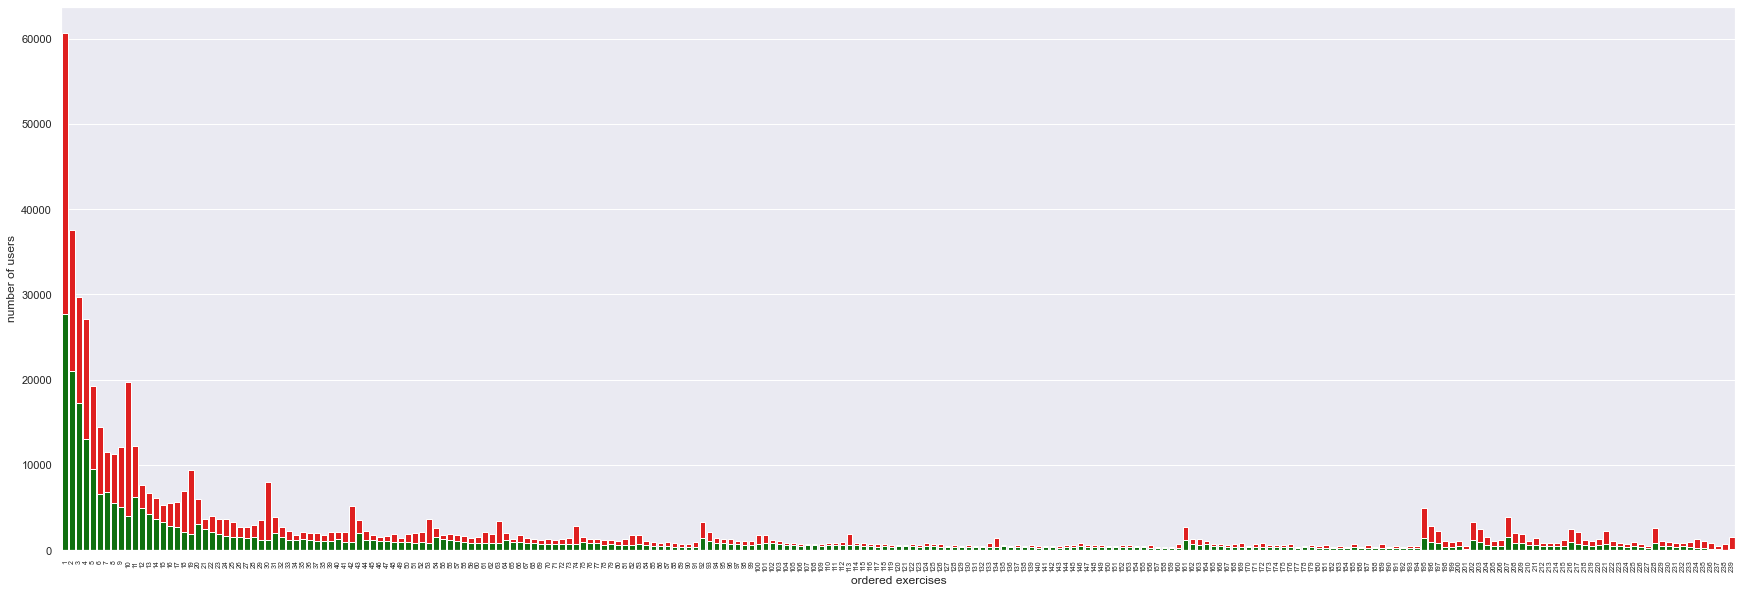

In [7]:
from visualizations import exercise_success_rate

## Activity of users for specific exercise in the same order as on webpage
exercise_success_rate(valid_final_logs, absolute_order_dict)

In [8]:
import importlib
import utils
importlib.reload(utils)
from utils import get_exercise_moves_thresholds, get_average_solving_times

# retrieved ids of groups with min threshold 150, 200, 300
threshold_150 = [141, 140, 142, 57] + exercise_groups[28][0]
threshold_200 = [68] + exercise_groups[25][0] + exercise_groups[26][0] + exercise_groups[27][0]
threshold_300 =  exercise_groups[23][0] + exercise_groups[24][0]

## create average solving time dictionary for exercises
exercise_average_times = get_average_solving_times(valid_final_logs)

def get_exercise_moves_chosen_thresholds(exercise_id, exercise_moves, size):
    return get_exercise_moves_thresholds(threshold_150, threshold_200, threshold_300, exercise_id, exercise_moves, size)


def get_exercise_moves_above_threshold(exercise_id, exercise_moves):
    min_moves =  100
    if exercise_id in threshold_150:
        min_moves = 150
    elif exercise_id in threshold_200:
        min_moves = 200
    elif exercise_id in threshold_300:
        min_moves = 300

    return exercise_moves - min_moves


## Visualizations
interactive visualizations (if not visible can be found in folder /interactive_viz)

In [21]:
import importlib
import visualizations
importlib.reload(visualizations)
from visualizations import create_user_activity_plotly, create_grouped_exercise_user_activity_plotly, create_chosen_users_graph

def get_user_logs_with_additional_info(data: pd.DataFrame, user_id: int, absolute_order_dict) -> pd.DataFrame:
    user_data = data[data['user'] == user_id]
    user_data.reset_index(inplace=True, drop=True)
    user_data.reset_index(inplace=True)
    user_data['item_order'] = user_data['item'].map(absolute_order_dict)
    user_data['time'].replace(to_replace=r'([0-9]{4}-[0-9]{2}-[0-9]{2}).*', value=r'\1', regex=True, inplace=True)
    user_data['correct'] = user_data['correct'].astype(str)
    user_data['moves_size_small'] = user_data.apply(lambda x: get_exercise_moves_chosen_thresholds(x.item, x.moves, "small"), axis=1)
    user_data['moves_size_large'] = user_data.apply(lambda x: get_exercise_moves_chosen_thresholds(x.item, x.moves, "large"), axis=1)
    return user_data


f = create_user_activity_plotly(get_user_logs_with_additional_info(valid_final_logs, 28850025, absolute_order_dict), data_item)
f.write_html("../interaktivne_viz/riesi_prvu_sadu.html")

Index(['index', 'id', 'user', 'item', 'answer', 'correct', 'moves',
       'responseTime', 'time', 'log_count', 'wpm', 'error_count', 'error_seq',
       'responseTime_hours', 'item_order', 'moves_size_small',
       'moves_size_large', 'item_name', 'color', 'resTimeSek'],
      dtype='object')


In [10]:
f = create_user_activity_plotly(get_user_logs_with_additional_info(valid_final_logs, 27289517, absolute_order_dict), data_item)
f.write_html("../interaktivne_viz/riesi_vela_uloh.html")

Index(['index', 'id', 'user', 'item', 'answer', 'correct', 'moves',
       'responseTime', 'time', 'log_count', 'wpm', 'error_count', 'error_seq',
       'responseTime_hours', 'item_order', 'moves_size_small',
       'moves_size_large', 'item_name', 'color', 'resTimeSek'],
      dtype='object')


In [22]:
f= create_grouped_exercise_user_activity_plotly(valid_final_logs, 30866947, exercise_to_group_dict, exercise_groups)
f.write_html("../interaktivne_viz/riesi_vela_uloh_sady.html")

plotly express hovertemplate: Sada úloh: %{y} <br>Počet riešených úloh: %{marker.size} <br>Úspešnosť riešených úloh: %{marker.color:.2f}<extra></extra>


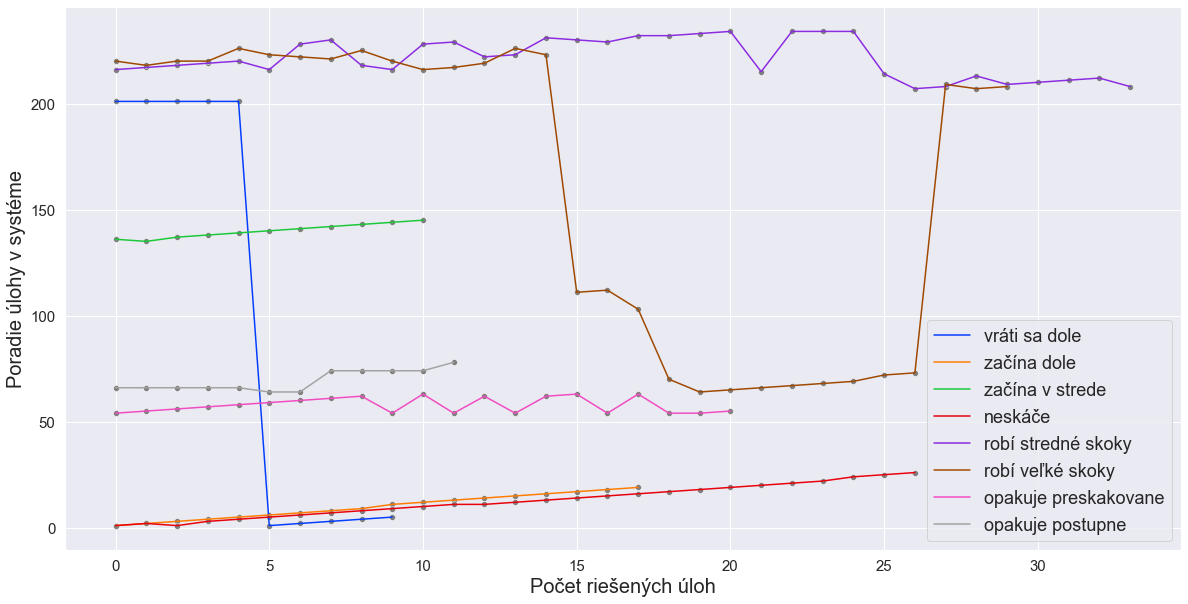

In [12]:
## chosen users to show specific behaviour in system
types = {29650451: 'vráti sa dole',
         27082843: 'začína dole',
         33903210: 'začína v strede', 
         32929478: 'neskáče', 
         27378367: 'robí stredné skoky', 
         26003273: 'robí veľké skoky', 
         32869237: 'opakuje preskakovane', 
         30330196: 'opakuje postupne'}

create_chosen_users_graph(valid_final_logs, pd.Series(types.keys()), absolute_order_dict, types)


In [23]:
## keyboard error visualization
import plotly.graph_objects as go
import data_analysis
importlib.reload(data_analysis)
from visualizations import create_keyboard
from data_analysis import get_number_of_errors_for_specific_char, create_error_heatmap, get_substitution_errors

# get text of exercises
def get_exercise_texts(data_item) -> typing.Dict[int, str]:
    exercise_texts = dict()
    for item_id, item in zip(data_item['id'], data_item['item']):
        exercise_texts[item_id] = json.loads(item)['text']
    return exercise_texts

exercise_texts = get_exercise_texts(data_item)

# only whole text exercises
whole_text_exercise_ids = []
for i in [205, 293, 296, 304, 235, 251, 236]:
    whole_text_exercise_ids += exercise_groups_temp[i]['group']

whole_text_exercise_logs = valid_final_logs[valid_final_logs['item'].isin(whole_text_exercise_ids)]


# raw_user_feature_set['user']
char_errors = get_number_of_errors_for_specific_char(whole_text_exercise_logs, [27289517] , exercise_texts)
char_errors = dict(sorted(char_errors.items(), key= lambda x: x[1]['total'], reverse=True))

## configure keyboard visualization
layout = go.Layout(
    plot_bgcolor='rgba(0,0,0,0)',
    yaxis=dict(scaleanchor="x", scaleratio=1, visible=False),
    xaxis=dict(visible=False),
    height=600,
    width=800,
)

fig = go.Figure(layout=layout)

## upper upper row with numbers and special chars
keys_val = ";+ěščřžýáíé=´ú)ů§¨,.-"
keys_full_val = [";</br></br>°", "+</br></br>1", "ě</br></br>2", "š</br></br>3", "č</br></br>4", "ř</br></br>5", "ž</br></br>6", "ý</br></br>7", "á</br></br>8", "í</br></br>9", "é</br></br>0", "=</br></br>%", "´</br></br>ˇ", "ú</br></br>/", ")</br></br>(", 'ů</br></br>"', "§</br></br>!", "¨</br></br>'", ",</br></br>?", ".</br></br>:", "-</br></br>_"]
specia_multiple_char_keys = dict(zip(keys_val, keys_full_val))
  
f = create_keyboard(fig, specia_multiple_char_keys, char_errors)
f.write_html("../interaktivne_viz/klavesnica_chyby.html")

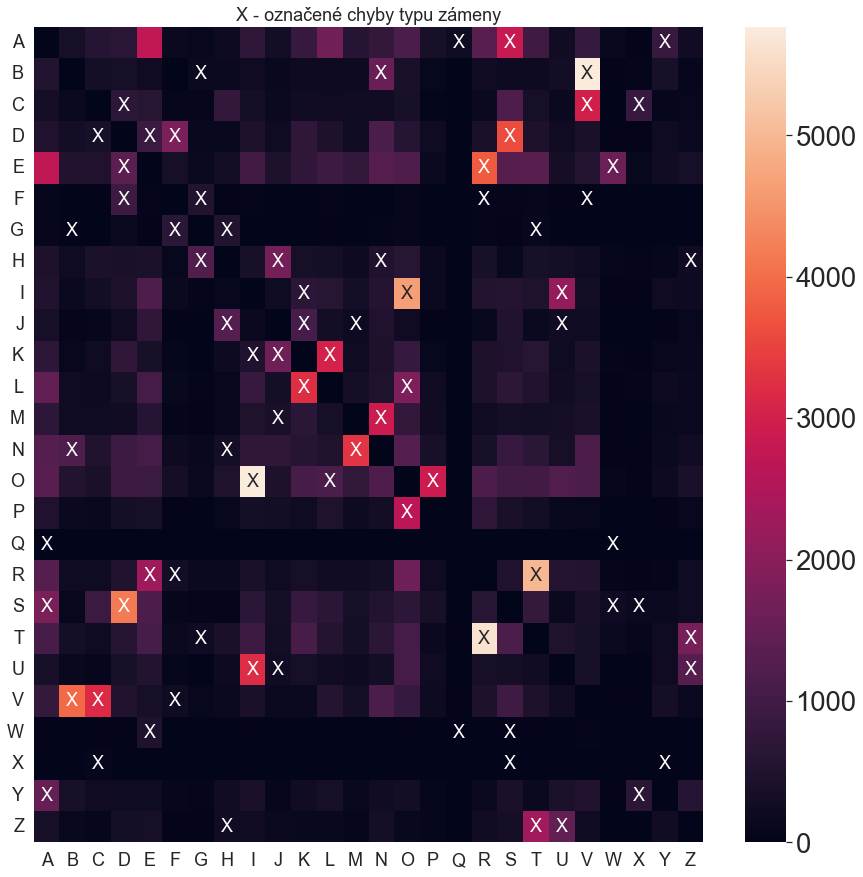

In [24]:
## create heat map from all errors for all users
all_char_errors = get_number_of_errors_for_specific_char(whole_text_exercise_logs[whole_text_exercise_logs['id'] > 1443482], whole_text_exercise_logs['user'].to_list() , exercise_texts, only_first_errors=True)

create_error_heatmap(all_char_errors)

In [25]:
total_errors, substitution_errors = get_substitution_errors(all_char_errors)
print('total number of errors: ', total_errors)
print('number of substitution errors: ', substitution_errors)
print('percentage of substitution errors', substitution_errors/total_errors)

total number of errors:  287788
number of substitution errors:  117351
percentage of substitution errors 0.4077689132277927


## Compute and transform features
compute different performance features and features based on specific behaviour patterns when solving exercises


In [26]:
# prepare data for clustering

def average_exercise_order_mean(series):
    res = 0
    for exercise_id in series:
        res += absolute_order_dict[exercise_id]
    return res / series.size

def average_exercise_order_mean25(series):
    if series.size // 4:
        first_logs = min(10, series.size//4)
        return average_exercise_order_mean(series.head(first_logs))
    return average_exercise_order_mean(series)

def average_exercise_order_mean75(series):
    if series.size // 4:
        last_logs = min(10, series.size//4)
        return average_exercise_order_mean(series.tail(last_logs))
    return average_exercise_order_mean(series)

def average_error_mean(series):
    res = 0
    for answer in series:
        if type(answer) == float:
            continue
        res += answer.count('|')
    return res / series.size

def average_distance_between_exercises(series):
    res = 0
    first = 0
    for i, exercise_id in enumerate(series):
        if i > 0:
            res += abs(absolute_order_dict[first] - absolute_order_dict[exercise_id])
        first = exercise_id
    return res / series.size

def longest_sequence(series):
    max_res = 0
    res = 0
    item_id = 0
    for i in series:
        order_id = absolute_order_dict[i]
        if item_id == 0:
            item_id = order_id
        if item_id == order_id - 1:
            res += 1
        elif item_id != order_id:
            max_res = max(max_res, res)
            res = 0
        item_id = order_id
    max_res = max(max_res, res)
    return max_res

def divide_number_days_to_intervals(day_count):
    if day_count > 6:
        return 7
    return day_count

def divide_average_distance_to_intervals(distance):
    if distance <= 1:
        return 1
    if 1 < distance <= 5:
        return 2
    return 3

def sets_of_exercises(series):
    completed = series[(series['moves_threshold'] >= 24) | (series['correct'] == 1)]
    completed = completed.drop_duplicates(subset=['item'])
    
    completed_sets = [0 for _ in range(len(exercise_groups))]

    for item in completed['item']:
        set_index = exercise_to_group_dict[item][1] - 1
        completed_sets[set_index] += 1
    for i in range(len(completed_sets)):
        completed_sets[i] = completed_sets[i] / len(exercise_groups[i+1][0])

    return pd.Series(completed_sets)


def get_raw_features_for_clustering(data: pd.DataFrame):
    data_copy = data.copy()
    ## compute all features
    data_copy['moves_threshold'] = data_copy.apply(lambda x: get_exercise_moves_chosen_thresholds(x['item'], x['moves'], 'large'), axis=1)
    data_copy['above_moves'] = data_copy.apply(lambda x: get_exercise_moves_above_threshold(x['item'], x['moves']), axis=1)
    data_copy['time'].replace(to_replace=r'([0-9]{4}-[0-9]{2}-[0-9]{2}).*', value=r'\1', regex=True, inplace=True)
    df = data_copy.groupby(['user']).agg(
        number_logs=('correct', 'count'),
        success_rate=('correct', 'mean'),
        number_dif_exercise=('item', 'nunique'),
        average_WPM=('wpm', 'mean'),
        average_exercise_order25 = ('item', average_exercise_order_mean25),
        average_exercise_order75 = ('item', average_exercise_order_mean75),
        average_exercise_order=('item', average_exercise_order_mean),
        average_exercise_distance=('item', average_distance_between_exercises),
        average_error=('answer', average_error_mean),
        average_moves=('above_moves', 'mean'),
        number_dif_days=('time', 'nunique'),
        max_exercise_order=('item', 'max'),
        longest_sequence=('item', longest_sequence)
    ).reset_index(level='user', col_level=1)
    
    df.astype({'number_logs': 'int32', 'number_dif_exercise': 'int32', 'number_dif_days': 'int32', 'success_rate': 'float32', 'average_WPM': 'float32'}).dtypes
    
    df['number_dif_days_week'] = df['number_dif_days'].apply(divide_number_days_to_intervals)
    df['average_exercise_distance_groups'] = df['average_exercise_distance'].apply(divide_average_distance_to_intervals)
    df['repeated_exercise_count'] = (df['number_logs'] - df['number_dif_exercise']) / df['number_logs']
    
    ## sorted exercise set names
    sorted_exercise_set_names = [group[1] for group in dict(sorted(exercise_groups.items())).values()]
    sets = pd.DataFrame()
    sets[sorted_exercise_set_names] = data_copy.groupby(['user']).apply(sets_of_exercises)
    sets = sets.reset_index()
    sets = sets.drop(columns=['user'])
    
    return pd.concat([df, sets], axis=1)

## scale features
def scale_transfrom_feature_data(df: pd.DataFrame, columns):
    scaler = MinMaxScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df

In [27]:
## final chosen features for experiments that needs to be scaled
scale_features = ['number_logs', 'number_dif_exercise', 'repeated_exercise_count', 'average_error', 'average_moves', 'average_exercise_distance', 'average_WPM', 'average_moves', 'average_exercise_order', 'average_exercise_order25', 'average_exercise_order75', 'max_exercise_order', 'number_dif_days', 'number_dif_days_week', 'average_exercise_distance_groups']

## get features for clustering 
raw_user_feature_set = get_raw_features_for_clustering(valid_final_logs)
raw_user_feature_set_10 = raw_user_feature_set[raw_user_feature_set["number_logs"] >= 10]

## scale features
transf_feature_set = raw_user_feature_set.copy()
transf_feature_set = scale_transfrom_feature_data(transf_feature_set, scale_features)

transf_10 = raw_user_feature_set_10.copy()
transf_10 = scale_transfrom_feature_data(transf_10, scale_features)

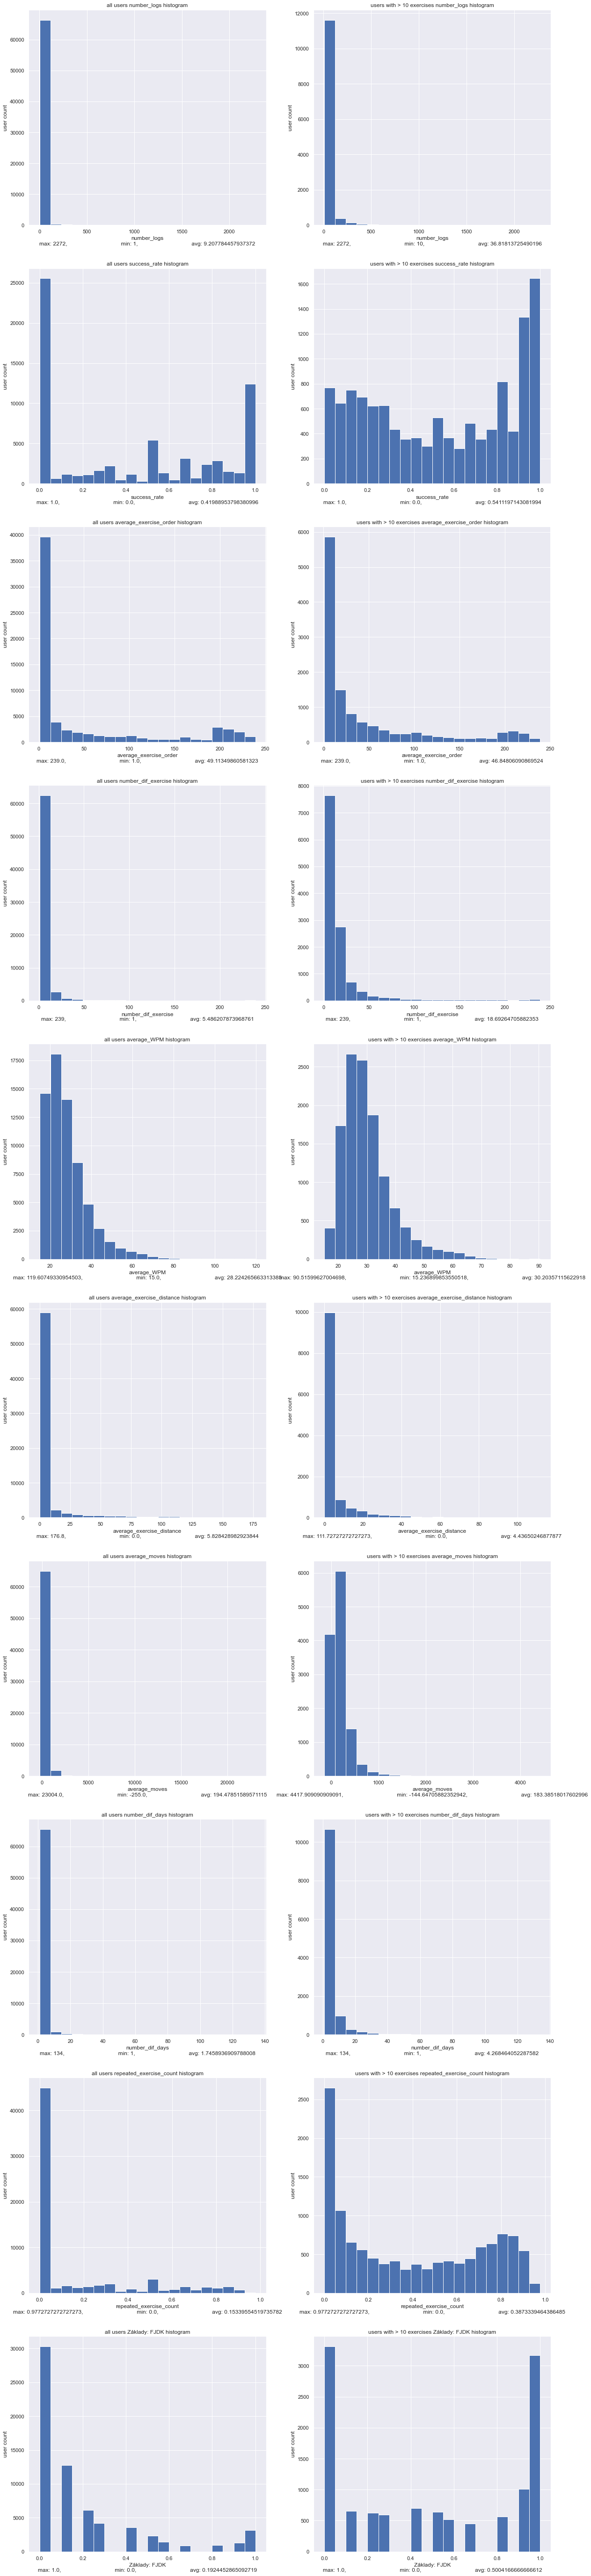

In [18]:
from visualizations import create_histograms

## show histograms of final features for every user / user with at least 10 opened exercises
features = ['number_logs', 'success_rate', 'average_exercise_order', 'number_dif_exercise', 'average_WPM', 'average_exercise_distance',
            'average_moves', 'number_dif_days', 'repeated_exercise_count', 'Základy: FJDK']

create_histograms([(feature, feature + ' histogram', feature, 'user count', 'linear') for feature in features], raw_user_feature_set, raw_user_feature_set_10, len(features))


## Best clustering
show used algorithms on best clustering found in experiments
1. clustering algorithms: DBSCAN, K-means
2. algorithms for optimal input parameters: Elbow method, K-distance graph
3. evaluation of clustering: silhouette analysis

number_logs-success_rate-average_exercise_order-number_dif_exercise-number_dif_days


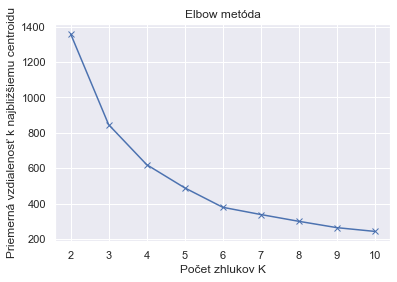

In [28]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# ELBOW METHOD
SAVE_GRAPHS = False
## best features from experiment
chosen_features = transf_10[['number_logs', 'success_rate', 'average_exercise_order', 'number_dif_exercise', 'number_dif_days']]
configuration_name = '-'.join(list(chosen_features.columns))
print(configuration_name)


def elbow_method(features, save, show_graph):
    sum_of_squared_distances = []
    K = range(2,11)
    for num_clusters in K :
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(features)
        sum_of_squared_distances.append(kmeans.inertia_)

    if show_graph:
        plt.plot(K,sum_of_squared_distances, 'bx-')
        plt.xlabel('Počet zhlukov K')
        plt.ylabel('Priemerná vzdialenosť k najbližšiemu centroidu')
        plt.title('Elbow metóda')
        if save:
            plt.savefig(f'graphs/{configuration_name}-ELBOW.png')
        plt.show()
        plt.close()
    else:
        return sum_of_squared_distances

elbow_method(chosen_features.to_numpy(), SAVE_GRAPHS, show_graph=True)

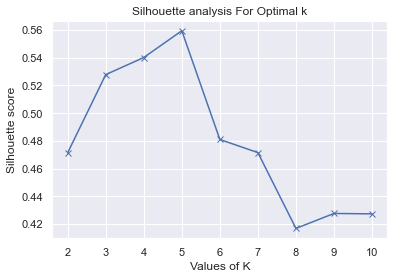

In [29]:
# SILHOUETTE ANALYSIS
def silhouette_analysis(data, save, show_graph):
    silhouette_avg = []
    K = range(2,11)

    for num_clusters in K:
        # initialise kmeans
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(data)
        cluster_labels = kmeans.labels_

        # silhouette score
        silhouette_avg.append(silhouette_score(data, cluster_labels))

    if show_graph:
        plt.plot(K, silhouette_avg,'bx-')
        plt.xlabel('Values of K')
        plt.ylabel('Silhouette score')
        plt.title('Silhouette analysis For Optimal k')
        if save:
            plt.savefig(f'graphs/{configuration_name}-SILHUETTE.png')
        plt.show()
        plt.close()
    else:
        return silhouette_avg

silhouette_analysis(chosen_features.to_numpy(), SAVE_GRAPHS, True)

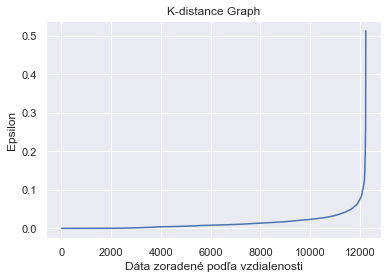

In [30]:
## neighbour graph for dbscan
from sklearn.neighbors import NearestNeighbors

## chosen minPts 
MIN_PTS = 20

def k_distane_method(data: pd.DataFrame):
    neigh = NearestNeighbors(n_neighbors=MIN_PTS)
    nbrs = neigh.fit(data)
    distances, _ = nbrs.kneighbors(data)

    # Plotting K-distance Graph
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    #plt.figure(figsize=(20,10))
    plt.plot(distances)
    plt.title('K-distance Graph')
    plt.xlabel('Dáta zoradené podľa vzdialenosti')
    plt.ylabel('Epsilon')
    plt.show()

k_distane_method(chosen_features)

In [31]:
NUMBER_OF_CLUSTERS = 5

kmeans = KMeans(n_clusters=NUMBER_OF_CLUSTERS).fit(chosen_features)
dbscan = DBSCAN(eps=0.2, min_samples=MIN_PTS).fit(chosen_features)

raw_user_feature_set_10['cluster'] = kmeans.labels_
raw_user_feature_set_10['dbscan'] = dbscan.labels_

print(raw_user_feature_set_10.groupby(['cluster'])['user'].count())
print(raw_user_feature_set_10.groupby(['dbscan'])['user'].count())


cluster
0    4896
1    4955
2    1067
3     947
4     375
Name: user, dtype: int64
dbscan
-1       72
 0    12168
Name: user, dtype: int64


## Visualization and interpretation of final clusters

Visualization of how "good" are the final clusters based on silhouette score

For n_clusters = 5 The average silhouette_score is : 0.5594309904267337
(0.0, 0.0, 0.0, 1.0)
(0.0, 0.0, 0.8667, 1.0)
(0.0, 0.6667, 0.5333, 1.0)
(0.0, 1.0, 0.0, 1.0)
(1.0, 0.6, 0.0, 1.0)


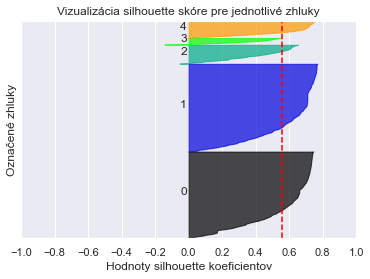

In [37]:
import visualizations
importlib.reload(visualizations)
from visualizations import silhouette_visualization
silhouette_visualization(chosen_features, NUMBER_OF_CLUSTERS)

In [24]:
# PCA visualization of clusters

def PCA_graph(features: pd.DataFrame, labels: np.ndarray, save):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(features)
    principalDf = pd.DataFrame(data = principalComponents
                , columns = ['principal component 1', 'principal component 2'])
    principalDf['cluster'] = labels

    plt.figure(figsize = (10,10))
    plt.title("2 Component PCA")
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    sns.scatterplot(x='principal component 1',
                   y='principal component 2',
                   data=principalDf,
                   hue = 'cluster',
                   palette='bright',
                   s = 20,
                   alpha=0.5)
    if save:
        plt.savefig(f'graphs/{configuration_name}-PCA.png')
    plt.show()
    plt.close()


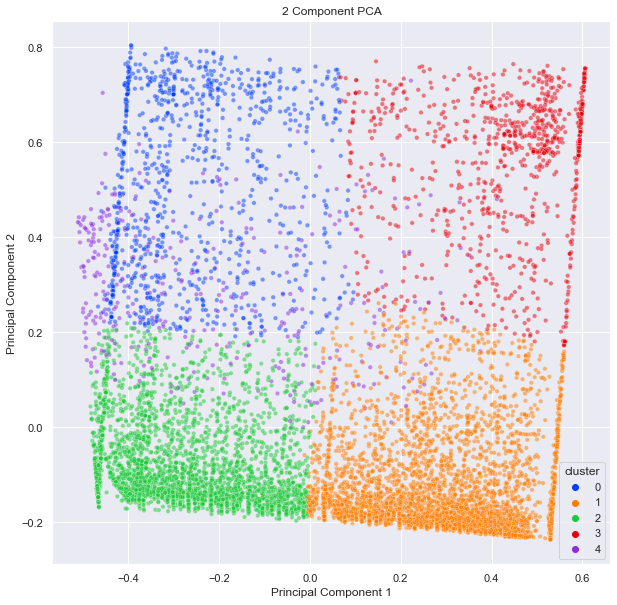

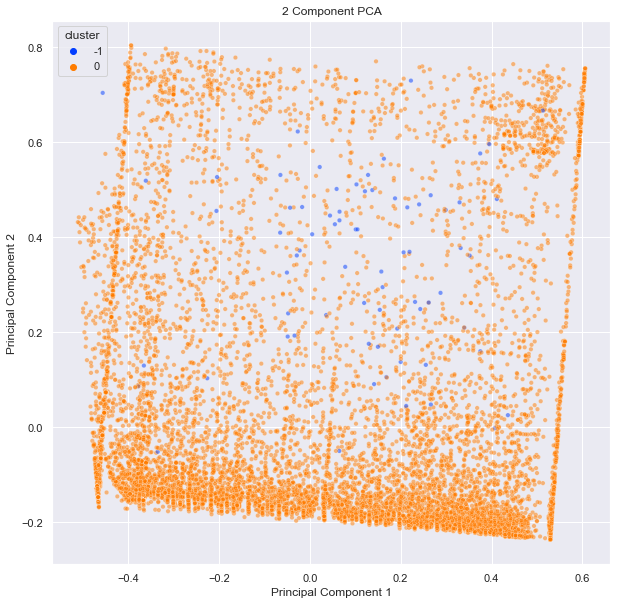

In [25]:
PCA_graph(chosen_features, kmeans.labels_, SAVE_GRAPHS)
PCA_graph(chosen_features, dbscan.labels_, SAVE_GRAPHS)


Visualization of individual feature distributions of clusters compared to all users

1. orange - users in cluster
2. blue - all users

1067


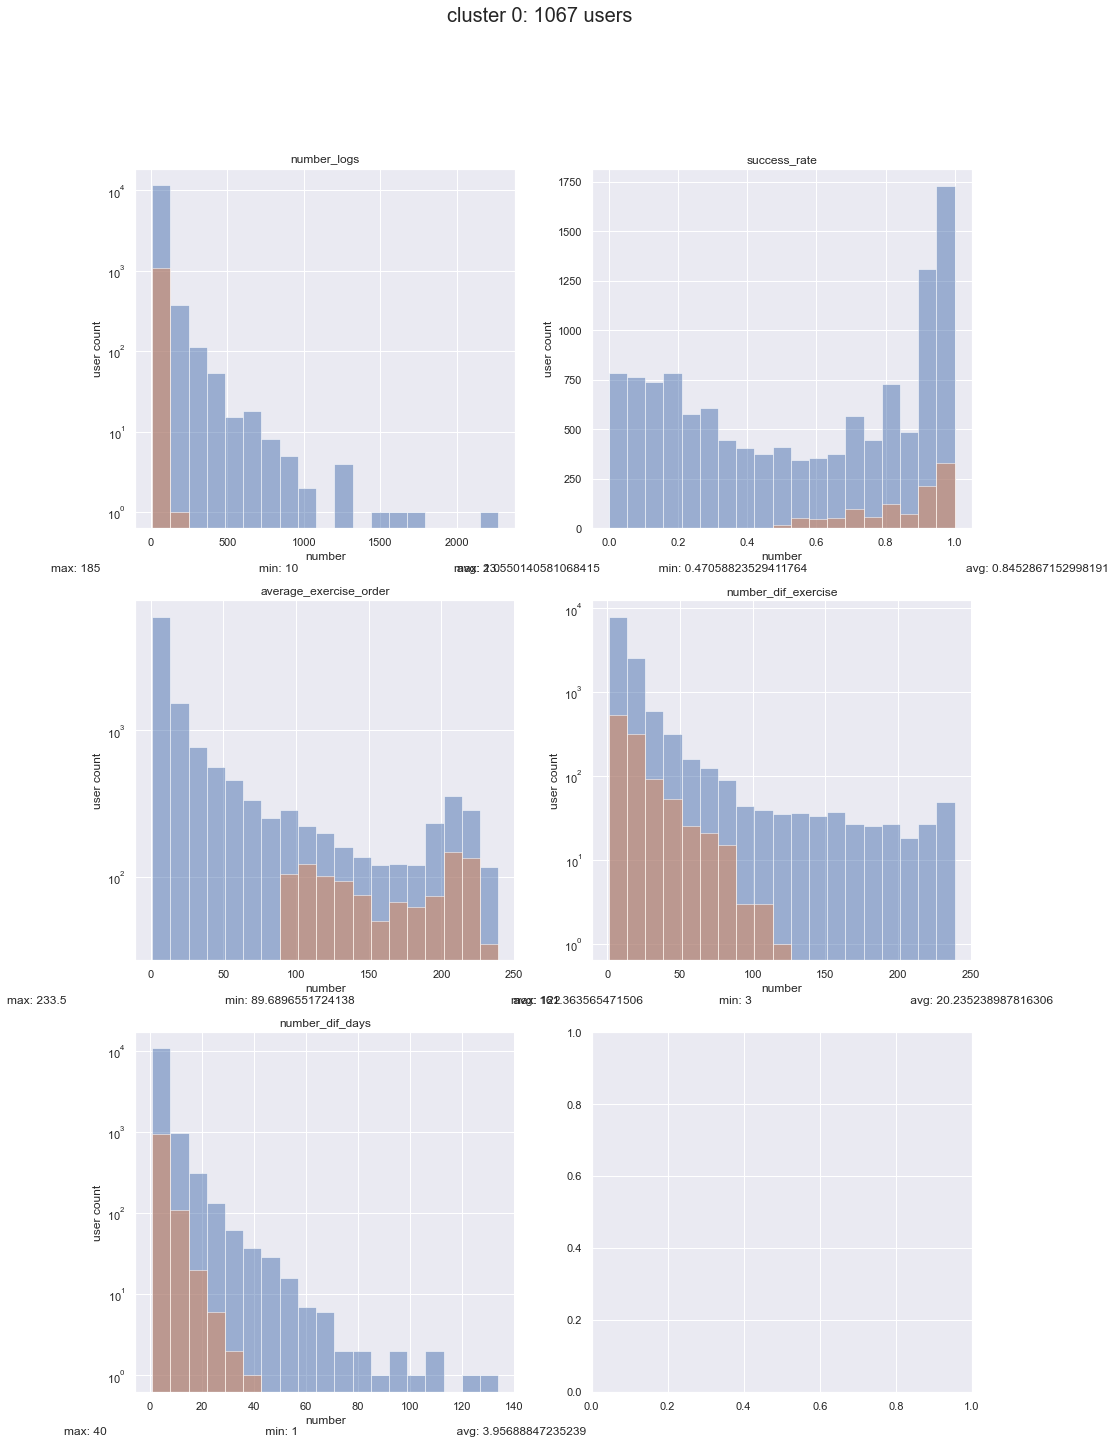

4896


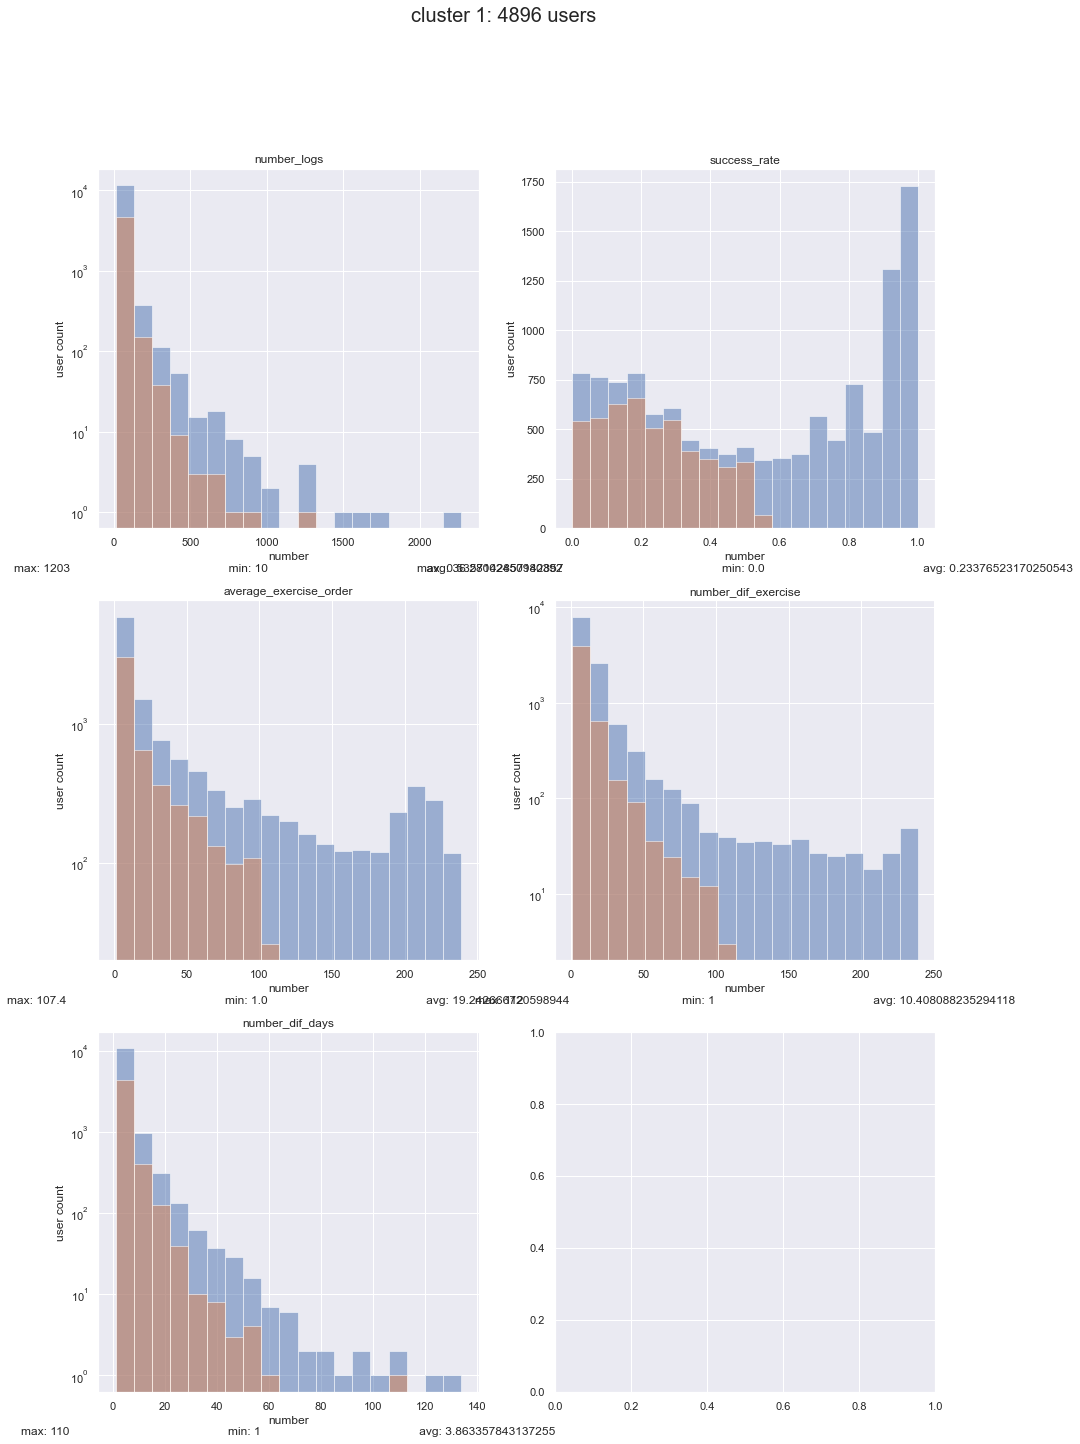

4955


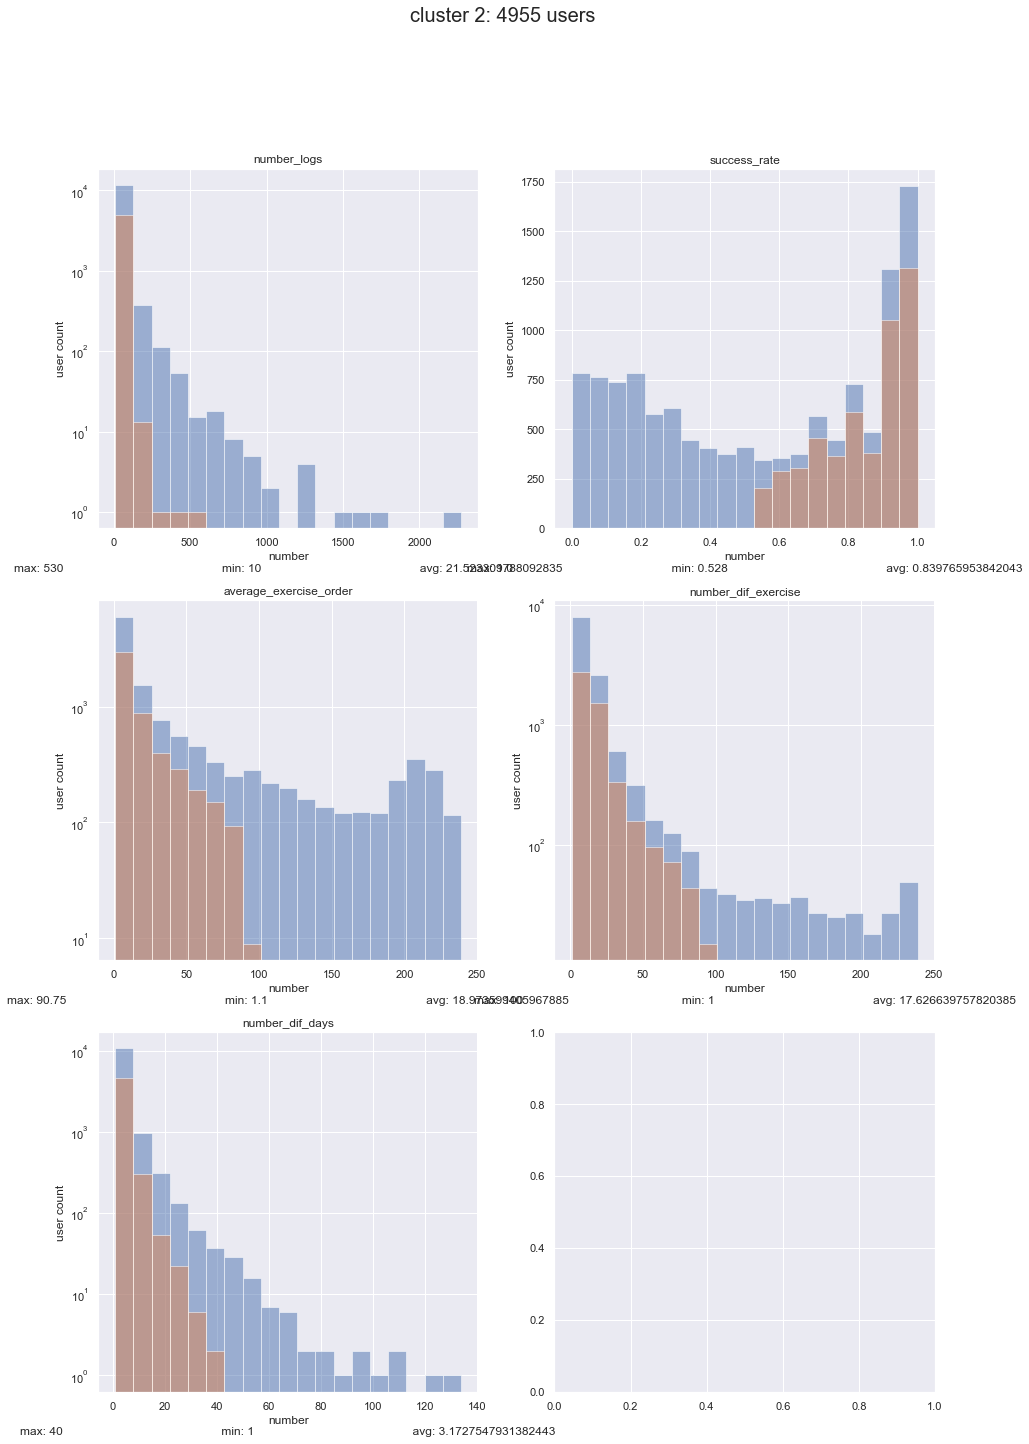

949


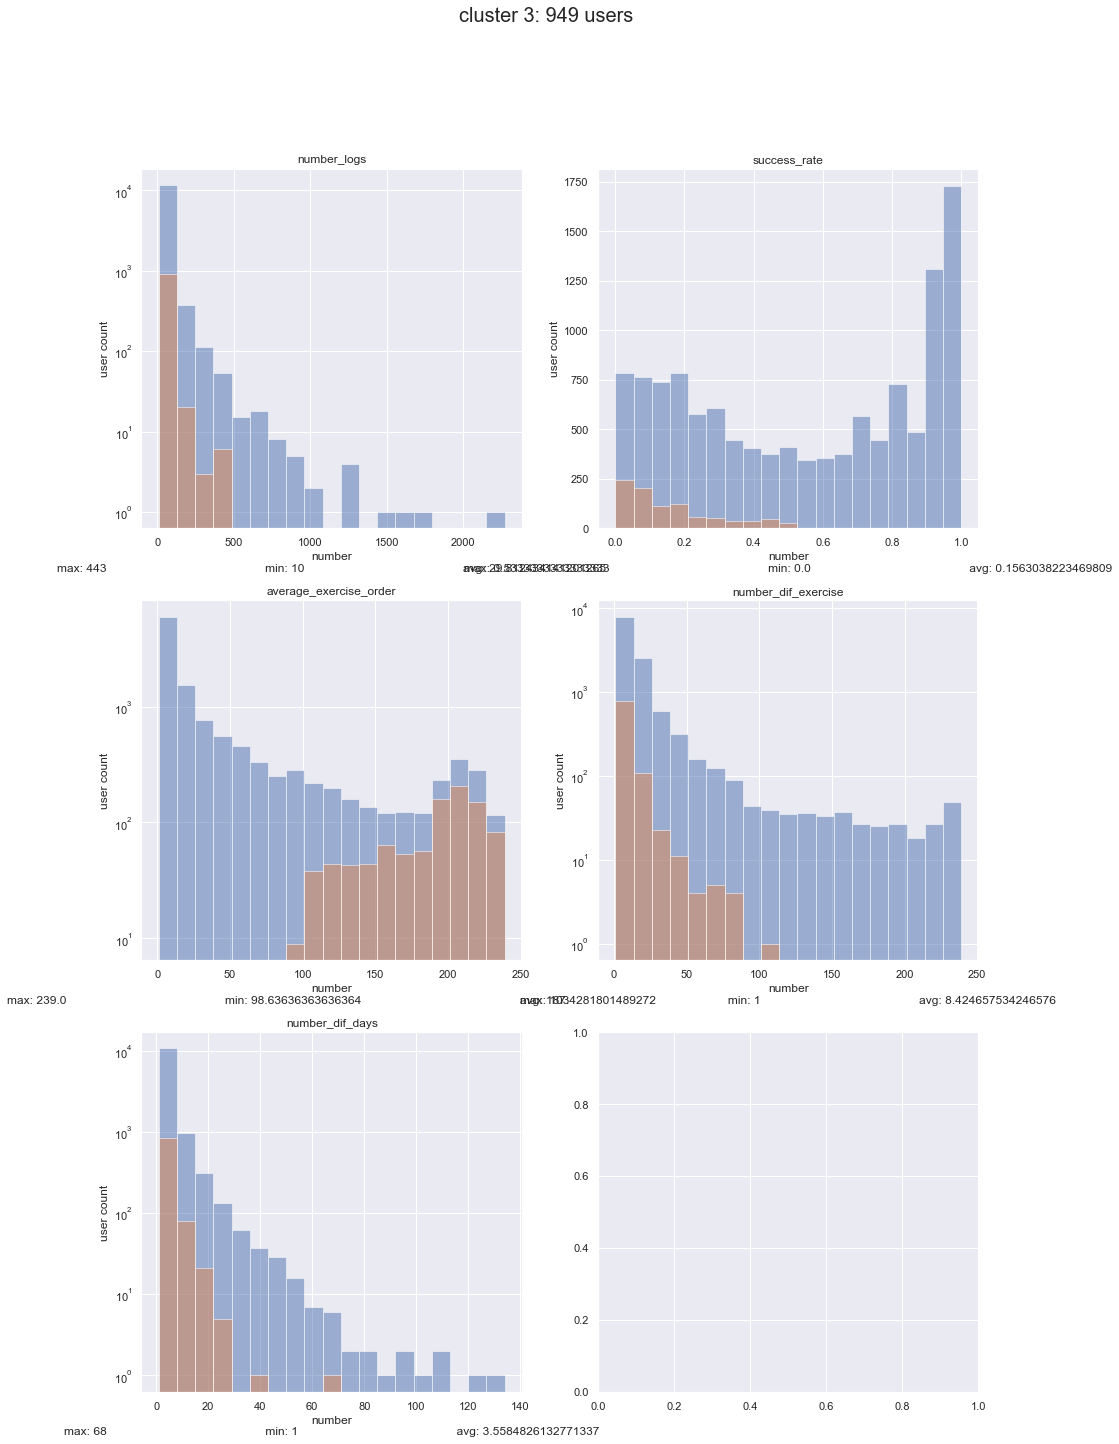

373


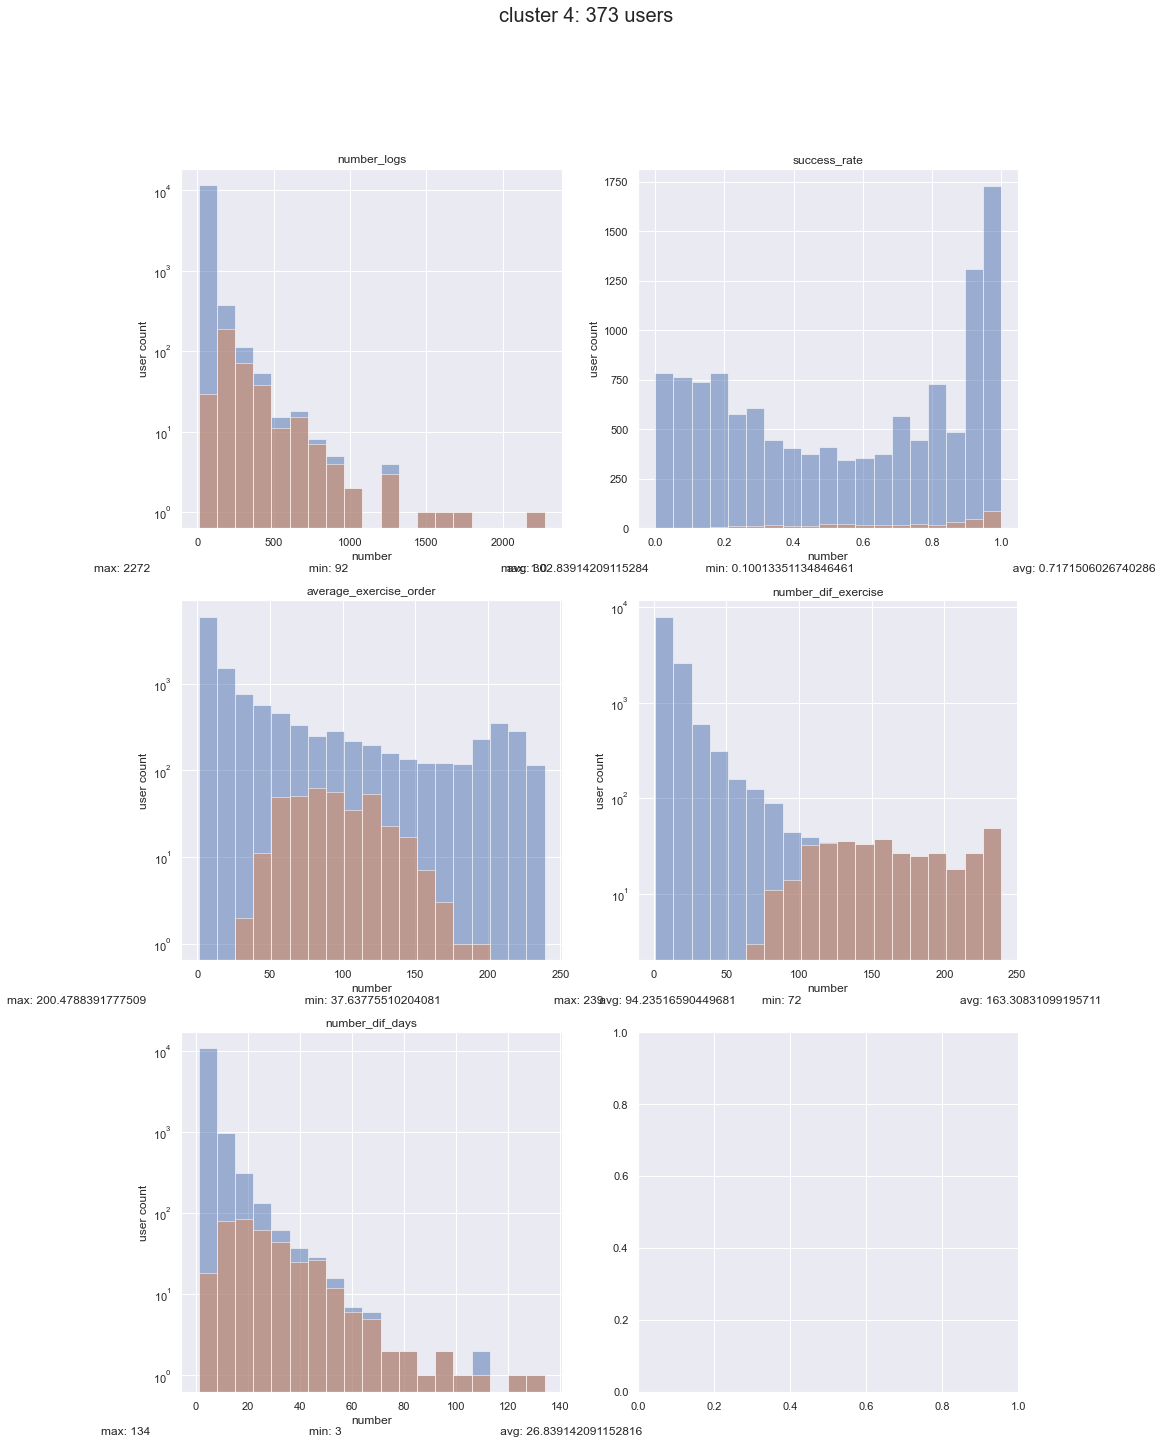

In [26]:
# clustered histograms
from visualizations import create_histograms_for_clusters


create_histograms_for_clusters([(name, name, "number", "user count") for name in chosen_features.columns], ['log', 'linear', 'log', 'log', 'log'], #+ [("repeated_exercise_count", 'average repeated exercise', 'average repeated exercise', 'user count'),], ['log', 'linear', 'log', 'log', 'log', 'linear', 'log', 'log', 'log', 'log'],
                                raw_user_feature_set_10, cluster_number=5, cluster_algo='cluster', feature_number=5, label_start=0)
                                

Interpret clusters with visualizations of user opened exercises, use only users with small/medium jumps between opened exercises for better clarity

In [27]:
## choose random users
def choose_random_users(data: pd.DataFrame, count: int, cluster: int) -> pd.Series:
    chosen_cluster_data = data[(data['cluster'] == cluster) & (data['average_exercise_distance'] < 8)]
    return chosen_cluster_data.sample(n=count)['user']

random_users0 = choose_random_users(raw_user_feature_set_10, count=30, cluster=0)
random_users1 = choose_random_users(raw_user_feature_set_10, count=30, cluster=1)
random_users2 = choose_random_users(raw_user_feature_set_10, count=30, cluster=2)
random_users3 = choose_random_users(raw_user_feature_set_10, count=30, cluster=3)
random_users4 = choose_random_users(raw_user_feature_set_10, count=30, cluster=4)



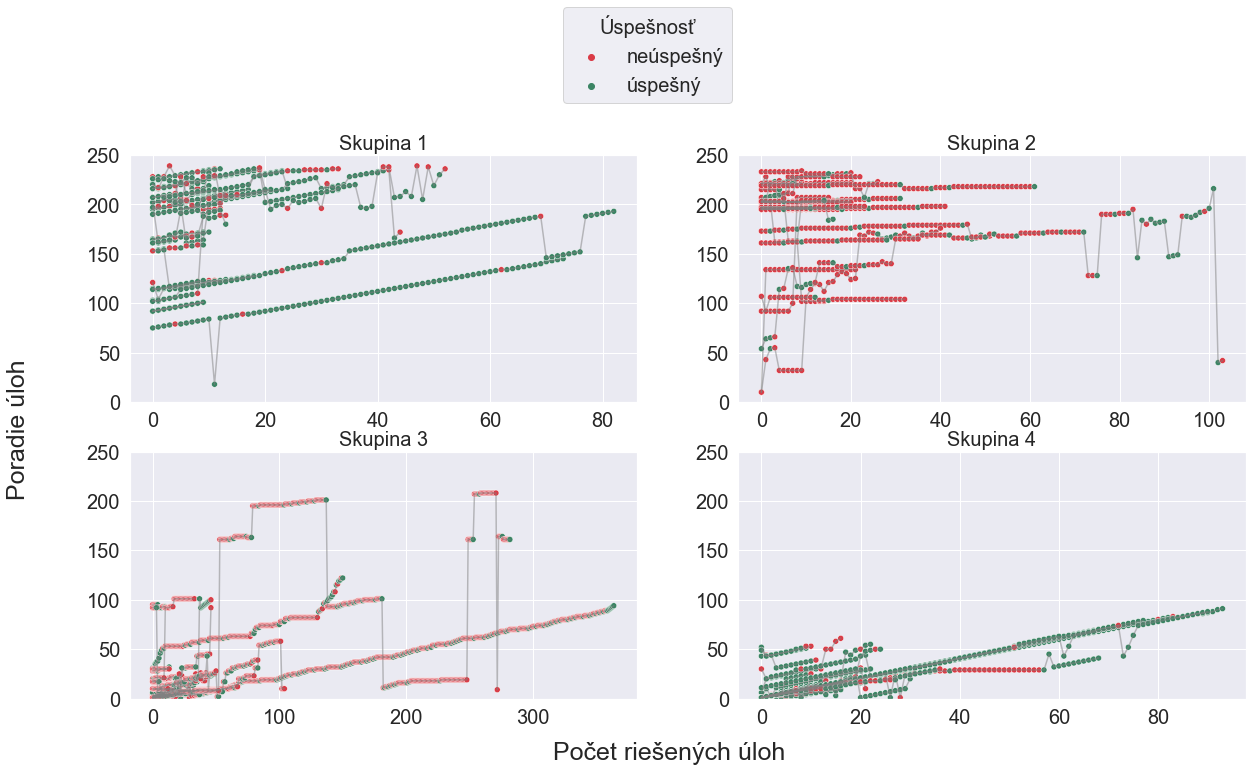

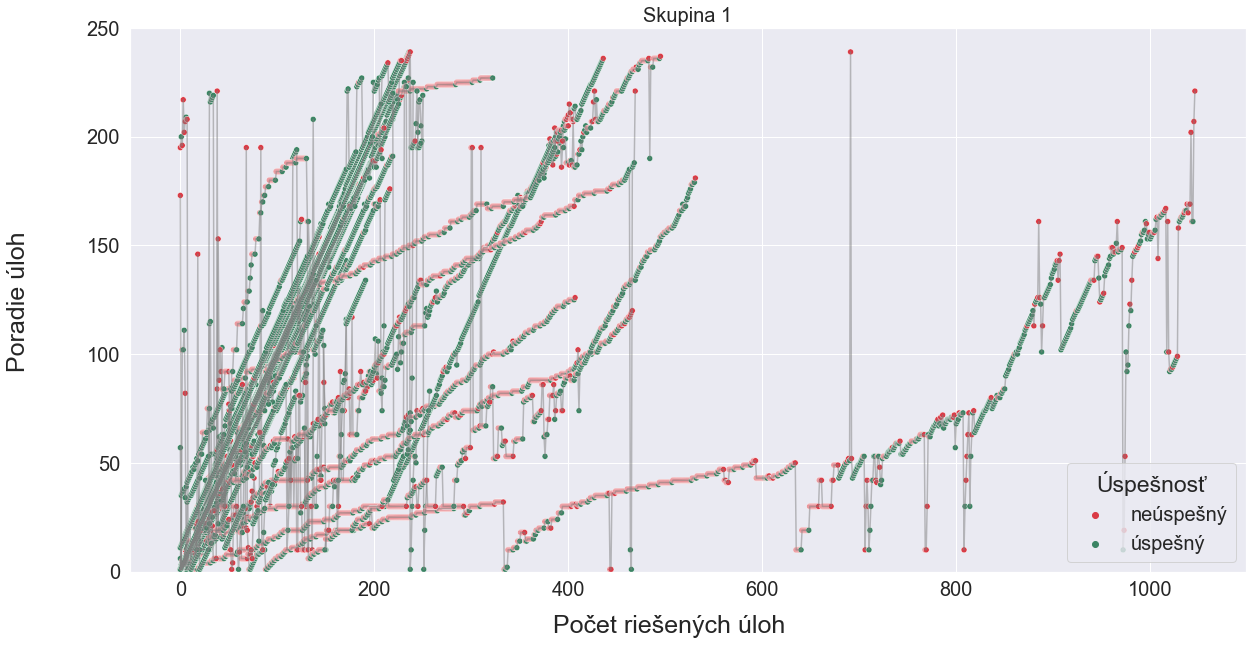

In [28]:
## create graph to compare multiple user behaviour from different clusters
import visualizations
importlib.reload(visualizations)
from visualizations import create_multiple_user_graph

create_multiple_user_graph(valid_final_logs, [random_users0, random_users3, random_users1, random_users2], absolute_order_dict, graph_dimensions=(2,2))
create_multiple_user_graph(valid_final_logs, [random_users4], absolute_order_dict)



Numbers of users with big jumps between exercises - could be separated from main group for further analysis

In [29]:
print('Number of users that do big jumps between exercises from 1 cluster: ', raw_user_feature_set_10[(raw_user_feature_set_10['cluster'] == 0) & (raw_user_feature_set_10['average_exercise_distance'] > 8)].shape[0])
print('Number of users that do big jumps between exercises from 2 cluster: ', raw_user_feature_set_10[(raw_user_feature_set_10['cluster'] == 1) & (raw_user_feature_set_10['average_exercise_distance'] > 8)].shape[0])
print('Number of users that do big jumps between exercises from 3 cluster: ', raw_user_feature_set_10[(raw_user_feature_set_10['cluster'] == 2) & (raw_user_feature_set_10['average_exercise_distance'] > 8)].shape[0])
print('Number of users that do big jumps between exercises from 4 cluster: ', raw_user_feature_set_10[(raw_user_feature_set_10['cluster'] == 3) & (raw_user_feature_set_10['average_exercise_distance'] > 8)].shape[0])
print('Number of users that do big jumps between exercises from 5 cluster: ', raw_user_feature_set_10[(raw_user_feature_set_10['cluster'] == 4) & (raw_user_feature_set_10['average_exercise_distance'] > 8)].shape[0])


Number of users that do big jumps between exercises from 1 cluster:  366
Number of users that do big jumps between exercises from 2 cluster:  542
Number of users that do big jumps between exercises from 3 cluster:  572
Number of users that do big jumps between exercises from 4 cluster:  260
Number of users that do big jumps between exercises from 5 cluster:  32
